In [1]:
import jax
import jax.numpy as jnp  # JAX NumPy
import optax  # Optimizers
import equinox as eqx  # Equinox

from flowMC.resource.model.common import MLP
from flowMC.resource.model.flowmatching.base import Solver, Path, CondOTScheduler, FlowMatchingModel
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt


In [2]:
# Optimization parameters
num_epochs = 100
batch_size = 10000
learning_rate = 1e-3
momentum = 0.9
n_samples = 10000
seed = 0

In [3]:
solver = Solver(MLP([3,64, 64,2], jax.random.PRNGKey(0), activation=jax.nn.swish))
path = Path(CondOTScheduler())
model = FlowMatchingModel(solver, path)

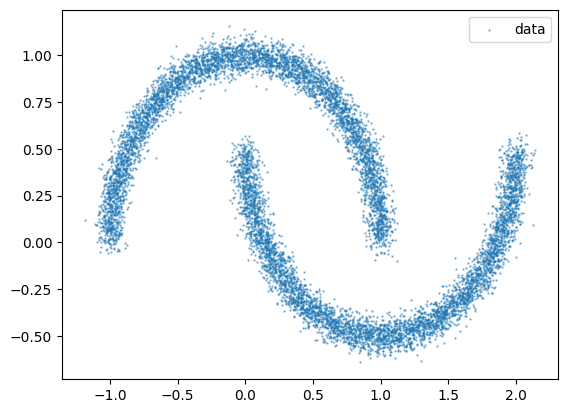

In [4]:
data = jnp.array(make_moons(n_samples, noise=0.05)[0])

plt.scatter(data[:, 0], data[:, 1], s=0.5, alpha=0.5, label="data")
plt.legend()

In [5]:

key = jax.random.PRNGKey(seed)

key, subkey = jax.random.split(key)
x0 = jax.random.normal(subkey, (data.shape[0], 2))  # Initial points
key, subkey = jax.random.split(key)
t = jax.random.uniform(subkey, (data.shape[0], 1), minval=0.0, maxval=1.0)  # Random time points

optim = optax.adam(learning_rate)
state = optim.init(eqx.filter(model, eqx.is_array))
key, subkey = jax.random.split(key)
key, trained_model, state, loss = model.train(
    key, (x0, data, t), optim, state, num_epochs, batch_size, verbose=True
)

Training NF:   0%|          | 0/100 [00:00<?, ?it/s]

Compiling training step


Training NF, current loss: 1.342: 100%|██████████| 100/100 [00:00<00:00, 137.26it/s]


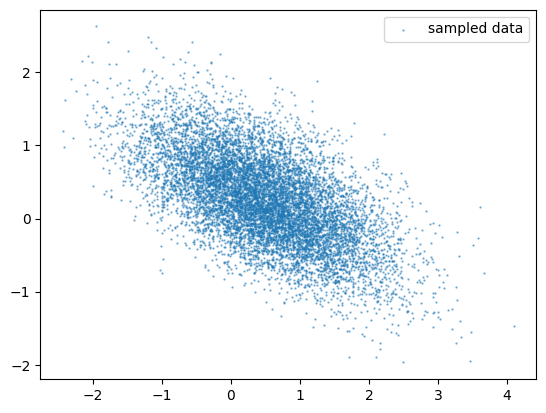

In [6]:
sampled_data = trained_model.sample(key, 10000, dt=0.1)
plt.scatter(sampled_data[:, 0], sampled_data[:, 1], s=0.5, alpha=0.5, label="sampled data")
plt.legend()
plt.show()

In [7]:
trained_model.log_prob(data)

Array([[-1.9285781 , -0.15285134],
       [-0.19273269, -0.6286325 ],
       [-0.7832123 , -0.1960336 ],
       ...,
       [-0.14614713, -0.76744205],
       [-0.46196693, -0.06765872],
       [-0.5942503 , -0.1033802 ]], dtype=float32)